## Module 4.2: Residual Blocks/Connections

We will see how to create residual blocks/connections layers for use in advanced convolutional neural networks.

We will:
- Implement basic and convoluted residual blocks. In the first case we will look at connections skipping single or multiple layers.
- Create basic models and visually examine the residual architecture.

Since we are looking at *layers* rather than networks, we will not solve a problem in this module. However it is a good exercise for you to try on your own to make use of these ideas to improve the CNN performance from module 2.2.

We import desired libraries.

In [ ]:
from keras.models import Model
from keras.layers import Input,Conv2D,Flatten,Dense,Add,BatchNormalization,Activation
from keras.utils import plot_model

import numpy as np

We will implement a function to create a block of simple residual layers.

In [ ]:
# Since all layers will have the same number of filters to ensure element wise
# addition we could do this without a vector of filter numbers. But it will help
# to use such vectors once we generalize.
def simple_residual_block (layer_in,filters):
  # Define first convolution layer
  prev_layer = Conv2D(filters[0], (3,3), padding='same', activation='relu')(layer_in)
    
  for f in range(1,len(filters)):
    # Define later convolution layers
    conv = Conv2D(filters[f], (3,3), padding='same', activation='relu')(prev_layer)
    # Define skip connection (& update prev_layer)
    prev_layer = Add()([prev_layer, conv]) 
  
  return prev_layer

Here we design a simple network with such a residual block, and plot the network architecture.

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 128 3584        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 128, 128 147584      conv2d_16[0][0]                  
__________________________________________________________________________________________________
add_11 (Add)                    (None, 128, 128, 128 0           conv2d_16[0][0]                  
                                                                 conv2d_17[0][0]            

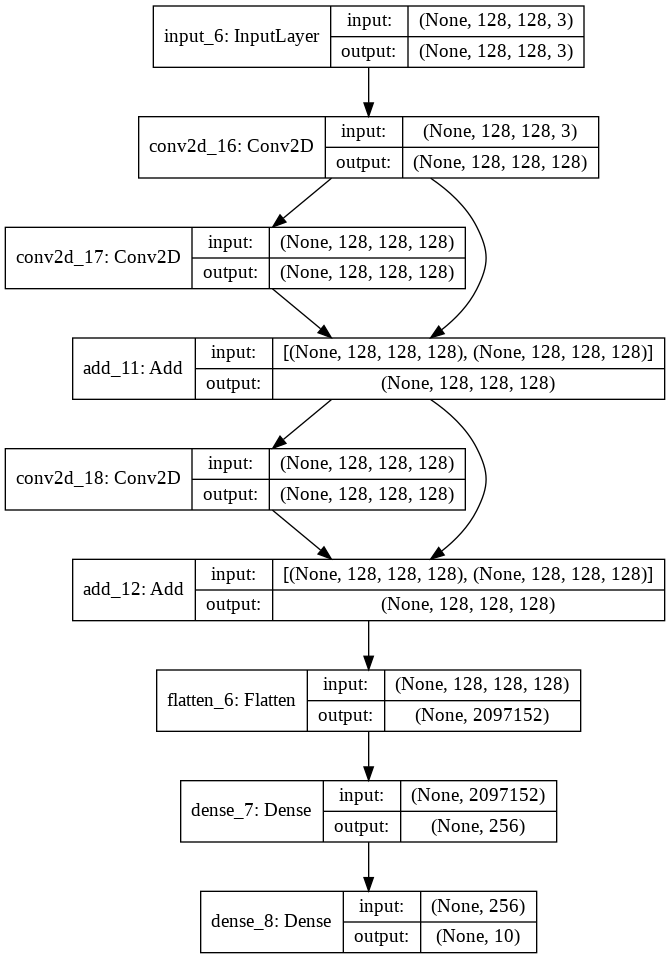

In [ ]:
# Define input
inputs = Input(shape=(128, 128, 3))
# Define residual block
res_block=simple_residual_block(inputs,[128,128,128])
# Flatten for output
flat = Flatten()(res_block)
dense1 = Dense(256, activation='relu')(flat)
outputs = Dense(10, activation='softmax')(dense1)
# Create model
model1 = Model(inputs=inputs, outputs=outputs)
# Summarize model
model1.summary()
# Plot model graph
plot_model(model1, show_shapes=True, to_file='residual_module.png')

Where we have multiple layers in a basic block - such as a convolution + batch normalization + activation set - we would skip the block. The same is true of convolution + pooling or convolution + dropout layer sets (though care has to be taken to ensure that the resulting outputs match in size, and these are not so commonly used in residual networks).

Let's redo our wrapper function to implement a block of residual layers with convolution + batch normalization + activation.

In [ ]:
# Since all layers will have the same number of filters to ensure element wise
# addition we could do this without a vector of filter numbers. But it will help
# to use such vectors once we generalize.
def batchnormed_residual_block (layer_in,filters):
  # Define first convolution layer
  prev_layer = Conv2D(filters[0], (3,3), padding='same', activation='relu')(layer_in)
    
  for f in range(1,len(filters)):
    # Define later convolution layers
    conv = Conv2D(filters[f], (3,3), padding='same')(prev_layer)
    batch = BatchNormalization()(conv)
    act = Activation("relu")(batch)
    # Define skip connection (& update prev_layer)
    prev_layer = Add()([prev_layer, act]) 
  
  return prev_layer

And let's design another simple network with two of these new residual blocks, and plot the network architecture.



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 147584      conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 128 512         conv2d_1[0][0]                   
______________________________________________________________________________________________

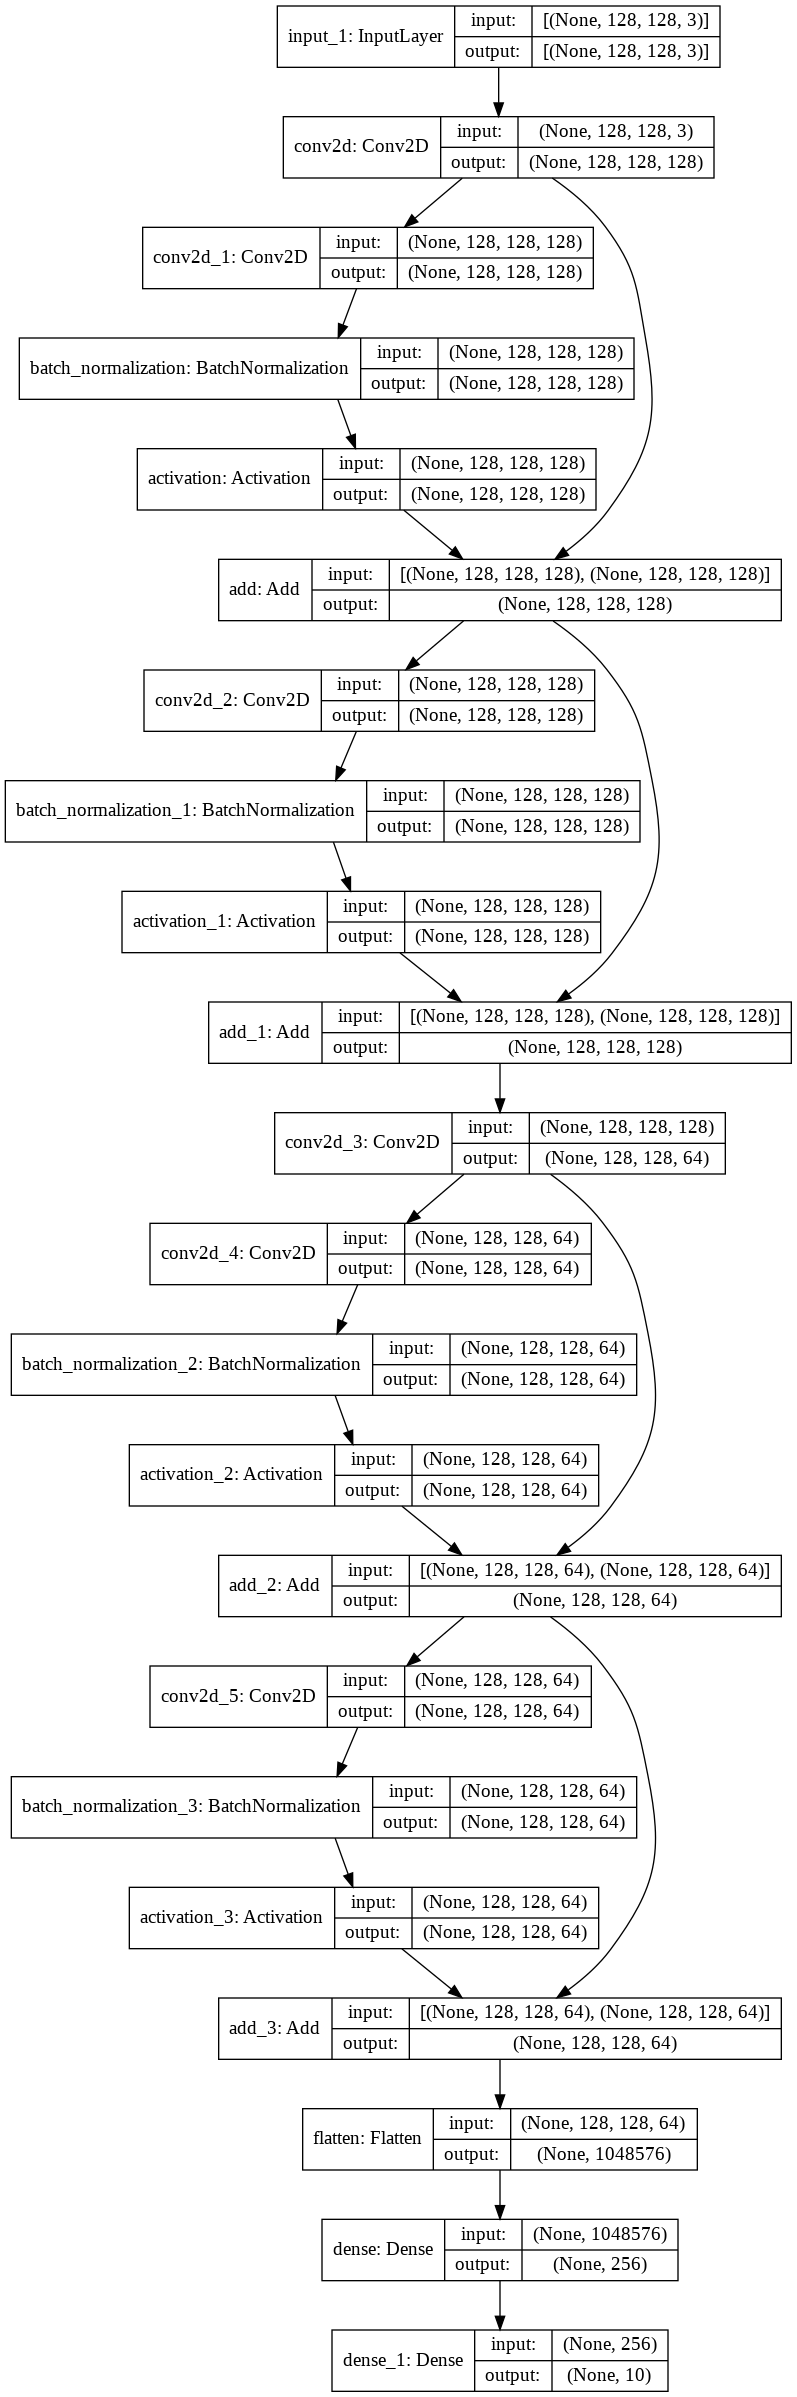

In [ ]:
# Define input
inputs = Input(shape=(128, 128, 3))
# Define first residual block
res_block1 = batchnormed_residual_block(inputs,[128,128,128])
# Define second residual block
res_block2 = batchnormed_residual_block(res_block1,[64,64,64])
# Flatten for output
flat = Flatten()(res_block2)
dense1 = Dense(256, activation='relu')(flat)
outputs = Dense(10, activation='softmax')(dense1)
# Create model
model1 = Model(inputs=inputs, outputs=outputs)
# Summarize model
model1.summary()
# Plot model graph
plot_model(model1, show_shapes=True, to_file='residual_module.png')

We may also want to skip sets of convolution (or convolution + other sets) layers. So let's design a wrapper for such a purpose.

In [ ]:
# Since all layers will have the same number of filters to ensure element wise
# addition we could do this without a vector of filter numbers. But it will help
# to use such vectors once we generalize.
def convset_residual_block (layer_in,filters,n):
  # Make internal function for defining set of convolution layers
  def make_conv_set(layer,f):
    for c in range(n):
      layer = Conv2D(filters[f], (3,3), padding='same', activation='relu')(layer)
    return layer

  # Define first set of convolution layers
  prev_layer=make_conv_set(layer_in,0)
    
  for f in range(1,len(filters)):
    # Define later set of convolution layers
    conv_set = make_conv_set(prev_layer,f)
    # Define skip connection (& update prev_layer)
    prev_layer = Add()([prev_layer, conv_set]) 
  
  return prev_layer

And let's design another simple network with two of these new residual blocks, and plot the network architecture.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 128 3584        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 128 147584      conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 128 147584      conv2d_19[0][0]                  
____________________________________________________________________________________________

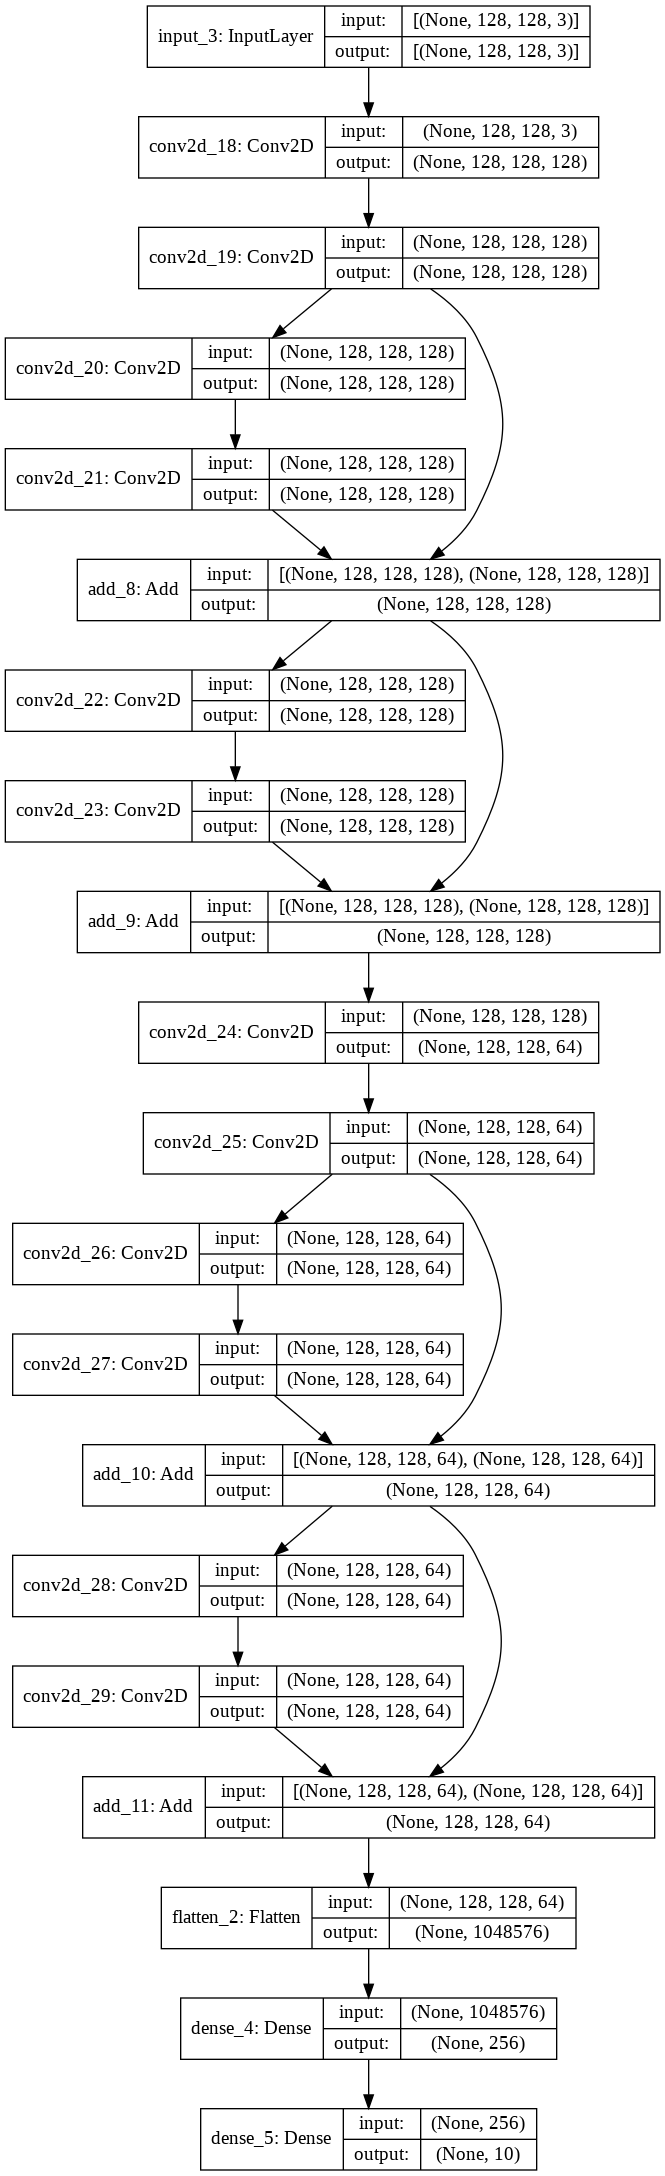

In [ ]:
inputs = Input(shape=(128, 128, 3))
# Define first *set* of convolution layers
conv1 = convset_residual_block(inputs,[128,128,128],2)
# Define second *set* of convolution layers
conv2 = convset_residual_block(conv1,[64,64,64],2)
# Flatten for output
flat = Flatten()(conv2)
dense1 = Dense(256, activation='relu')(flat)
outputs = Dense(10, activation='softmax')(dense1)
# Create model
model1 = Model(inputs=inputs, outputs=outputs)
# Summarize model
model1.summary()
# Plot model graph
plot_model(model1, show_shapes=True, to_file='residual_module.png')

In our last example we create a wrapper function to define a residual block of convolution blocks where the shape of the output has changed. We add a convolution layer to the skip connection designed to suitably shape it for the desired addition. 

In [ ]:
# Filters will be a 2d numpy array, giving filters for each convolution layer
# for each block (rows=block,columns=filter)
def dimchanged_convset_residual_block (layer_in,filters):
  # Make internal function for defining set of convolution layers
  def make_conv_set(layer,f_):
    for i in range(filters.shape[1]):
      layer = Conv2D(filters[f_,i], (3,3), activation='relu')(layer)
    return layer

  # Define first set of convolution layers
  prev_layer=make_conv_set(layer_in,0)
  
  # Work out dimensionality of skip convolution filter
  # (We know all filters in normal convolution layers are 3x3)
  skip_filter_dim=(2*filters.shape[1]+1,2*filters.shape[1]+1)
    
  for f in range(1,len(filters)):
    # Define later set of convolution layers
    conv_set = make_conv_set(prev_layer,f)
    # Define skip connection (& update prev_layer)
    # We need a convolution layer designed to match shapes    
    skip_conv = Conv2D(filters[f,-1], skip_filter_dim, activation='relu')(prev_layer)
    prev_layer = Add()([conv_set, skip_conv]) 
  
  return prev_layer

And we create another simple network with one of these new re-sizing residual blocks, and plot the network architecture.

128
(?, 116, 116, 128)
(?, 116, 116, 128)
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 126, 126, 64) 1792        input_27[0][0]                   
__________________________________________________________________________________________________
conv2d_126 (Conv2D)             (None, 124, 124, 128 73856       conv2d_125[0][0]                 
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 122, 122, 256 295168      conv2d_126[0][0]                 
_________________________________________________

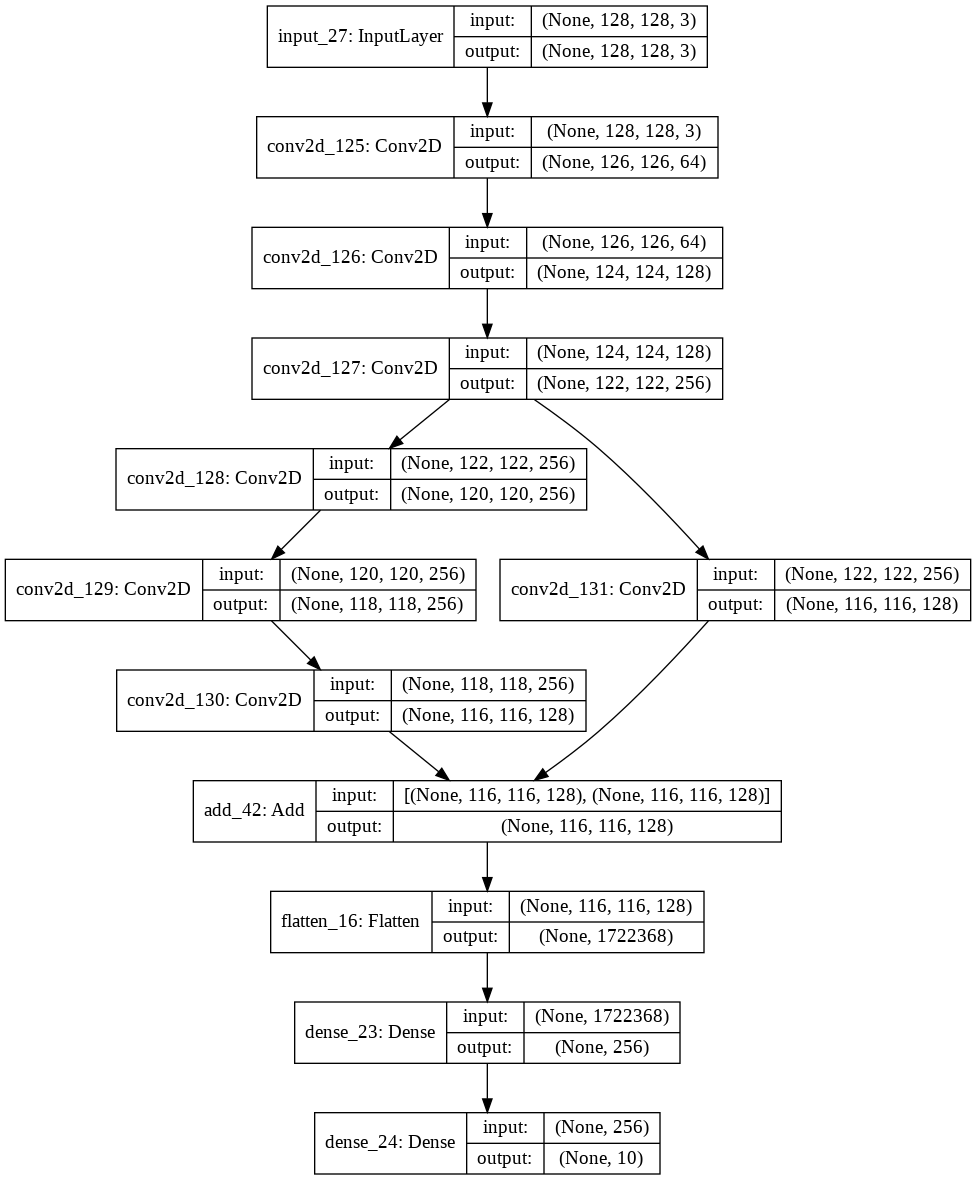

In [ ]:
inputs = Input(shape=(128, 128, 3))
# Define residual block of blocks of convolution layers that alter dimensionality.
filters=np.array([[64,128,256],[256,256,128]])
res_block=dimchanged_convset_residual_block(inputs,filters)
# Flatten for output
flat = Flatten()(res_block)
dense1 = Dense(256, activation='relu')(flat)
outputs = Dense(10, activation='softmax')(dense1)
# Create model
model1 = Model(inputs=inputs, outputs=outputs)
# Summarize model
model1.summary()
# Plot model graph
plot_model(model1, show_shapes=True, to_file='residual_module.png')

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Sat Apr 17 00:17:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np

from sklearn.metrics import confusion_matrix,classification_report

from keras.datasets import cifar10
from keras import Model
from keras.layers import Dense,Dropout,Flatten,Activation,Input,Add,BatchNormalization,Activation
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.utils import plot_model

import matplotlib.pyplot as plt

In [3]:
# Load images
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Make versions of the labels that are one-hot vectors
train_labels_array=np_utils.to_categorical(train_labels, 10)
test_labels_array=np_utils.to_categorical(test_labels, 10)

# Make vector of classnames
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
# Create inception module
def inception_module(layer_in, f1, f3_in, f3_out, f5_in, f5_out, mp_out):
  # 1x1 Convolution
  conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
  # drop1 = Dropout(0.5)(pool1)
  # 3x3 Convolution
  conv3 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
  conv3 = Conv2D(f3_out, (3,3), padding='same', activation='relu')(conv3)
  # 5x5 Convolution
  conv5 = Conv2D(f5_in, (1,1), padding='same', activation='relu')(layer_in)
  conv5 = Conv2D(f5_out, (5,5), padding='same', activation='relu')(conv5)
  # 3x3 Max Pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(mp_out, (1,1), padding='same', activation='relu')(pool)
  # Concatenate
  layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)

  # drop1 = Dropout(0.5)(layer_out)
  return layer_out

In [11]:
def convset_residual_block (layer_in,filters,n,strides):
  # Make internal function for defining set of convolution layers
  def make_conv_set(layer,strides,f_):
    for c in range(n):
      layer = Conv2D(filters[f_], strides, padding='same')(layer)
    return layer

  # Define first set of convolution layers
  prev_layer=make_conv_set(layer_in,strides,0)
    
  for f in range(1,len(filters)):
    # Define later set of convolution layers
    conv = make_conv_set(prev_layer,strides,f)
    batch = BatchNormalization()(conv)
    act = Activation("relu")(batch)    
    # Define skip connection (& update prev_layer)
    prev_layer = Add()([prev_layer, act]) 
  
  return prev_layer

def residual_with_inception (layer_in,strides,n,f1, f3_in, f3_out, f5_in, f5_out, mp_out):
  # combine inception model with residual 
  def getInception(layer):
    return inception_module(layer,f1, f3_in, f3_out, f5_in, f5_out, mp_out)

  # prev_layer = Conv2D(64,strides,padding='same')(layer_in)
  prev_layer = layer_in

  skip_layer_dim = f1+f3_out+f5_out+mp_out

  for f in range(1, n):
    conv = getInception(prev_layer)
    skip_conv = Conv2D(skip_layer_dim,strides,padding='same', activation='relu')(prev_layer)
    prev_layer = Add()([conv, skip_conv])

  return prev_layer


def getModel():
  inputs = Input(shape=(32, 32, 3),name="Input")
  # Define first *set* of convolution layers
  # conv_set1 = convset_residual_block(inputs,[32,32,32],1,3)
  conv_set1 = residual_with_inception(inputs,3,3,64, 64, 128, 16, 32, 32)
  conv_set2 = residual_with_inception(conv_set1,5,3,64, 64, 128, 16, 32, 32)
  # conv_set3 = residual_with_inception(conv_set2,7,3,64, 64, 128, 16, 32, 32)
  # Define second *set* of convolution layers
  # conv_set2 = convset_residual_block(conv_set1,[64,64,64],1,5)
  pool1 = MaxPooling2D((2, 2))(conv_set2)
  drop1 = Dropout(0.5)(pool1)
  conv2 = Conv2D(64, 5, activation='relu')(drop1)
  pool2 = MaxPooling2D((2, 2))(conv2)
  drop2 = Dropout(0.5)(pool2)
  conv3 = Conv2D(32, 3, activation='relu')(drop2)   
  # Flatten for output
  flat = Flatten()(conv3)
  drop = Dropout(0.5)(flat)
  dense1 = Dense(256, activation='relu')(drop)
  outputs = Dense(10, activation='softmax')(dense1)
  # Create model
  model = Model(inputs=inputs, outputs=outputs)
  return model

model=getModel()
opt=Adam()

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

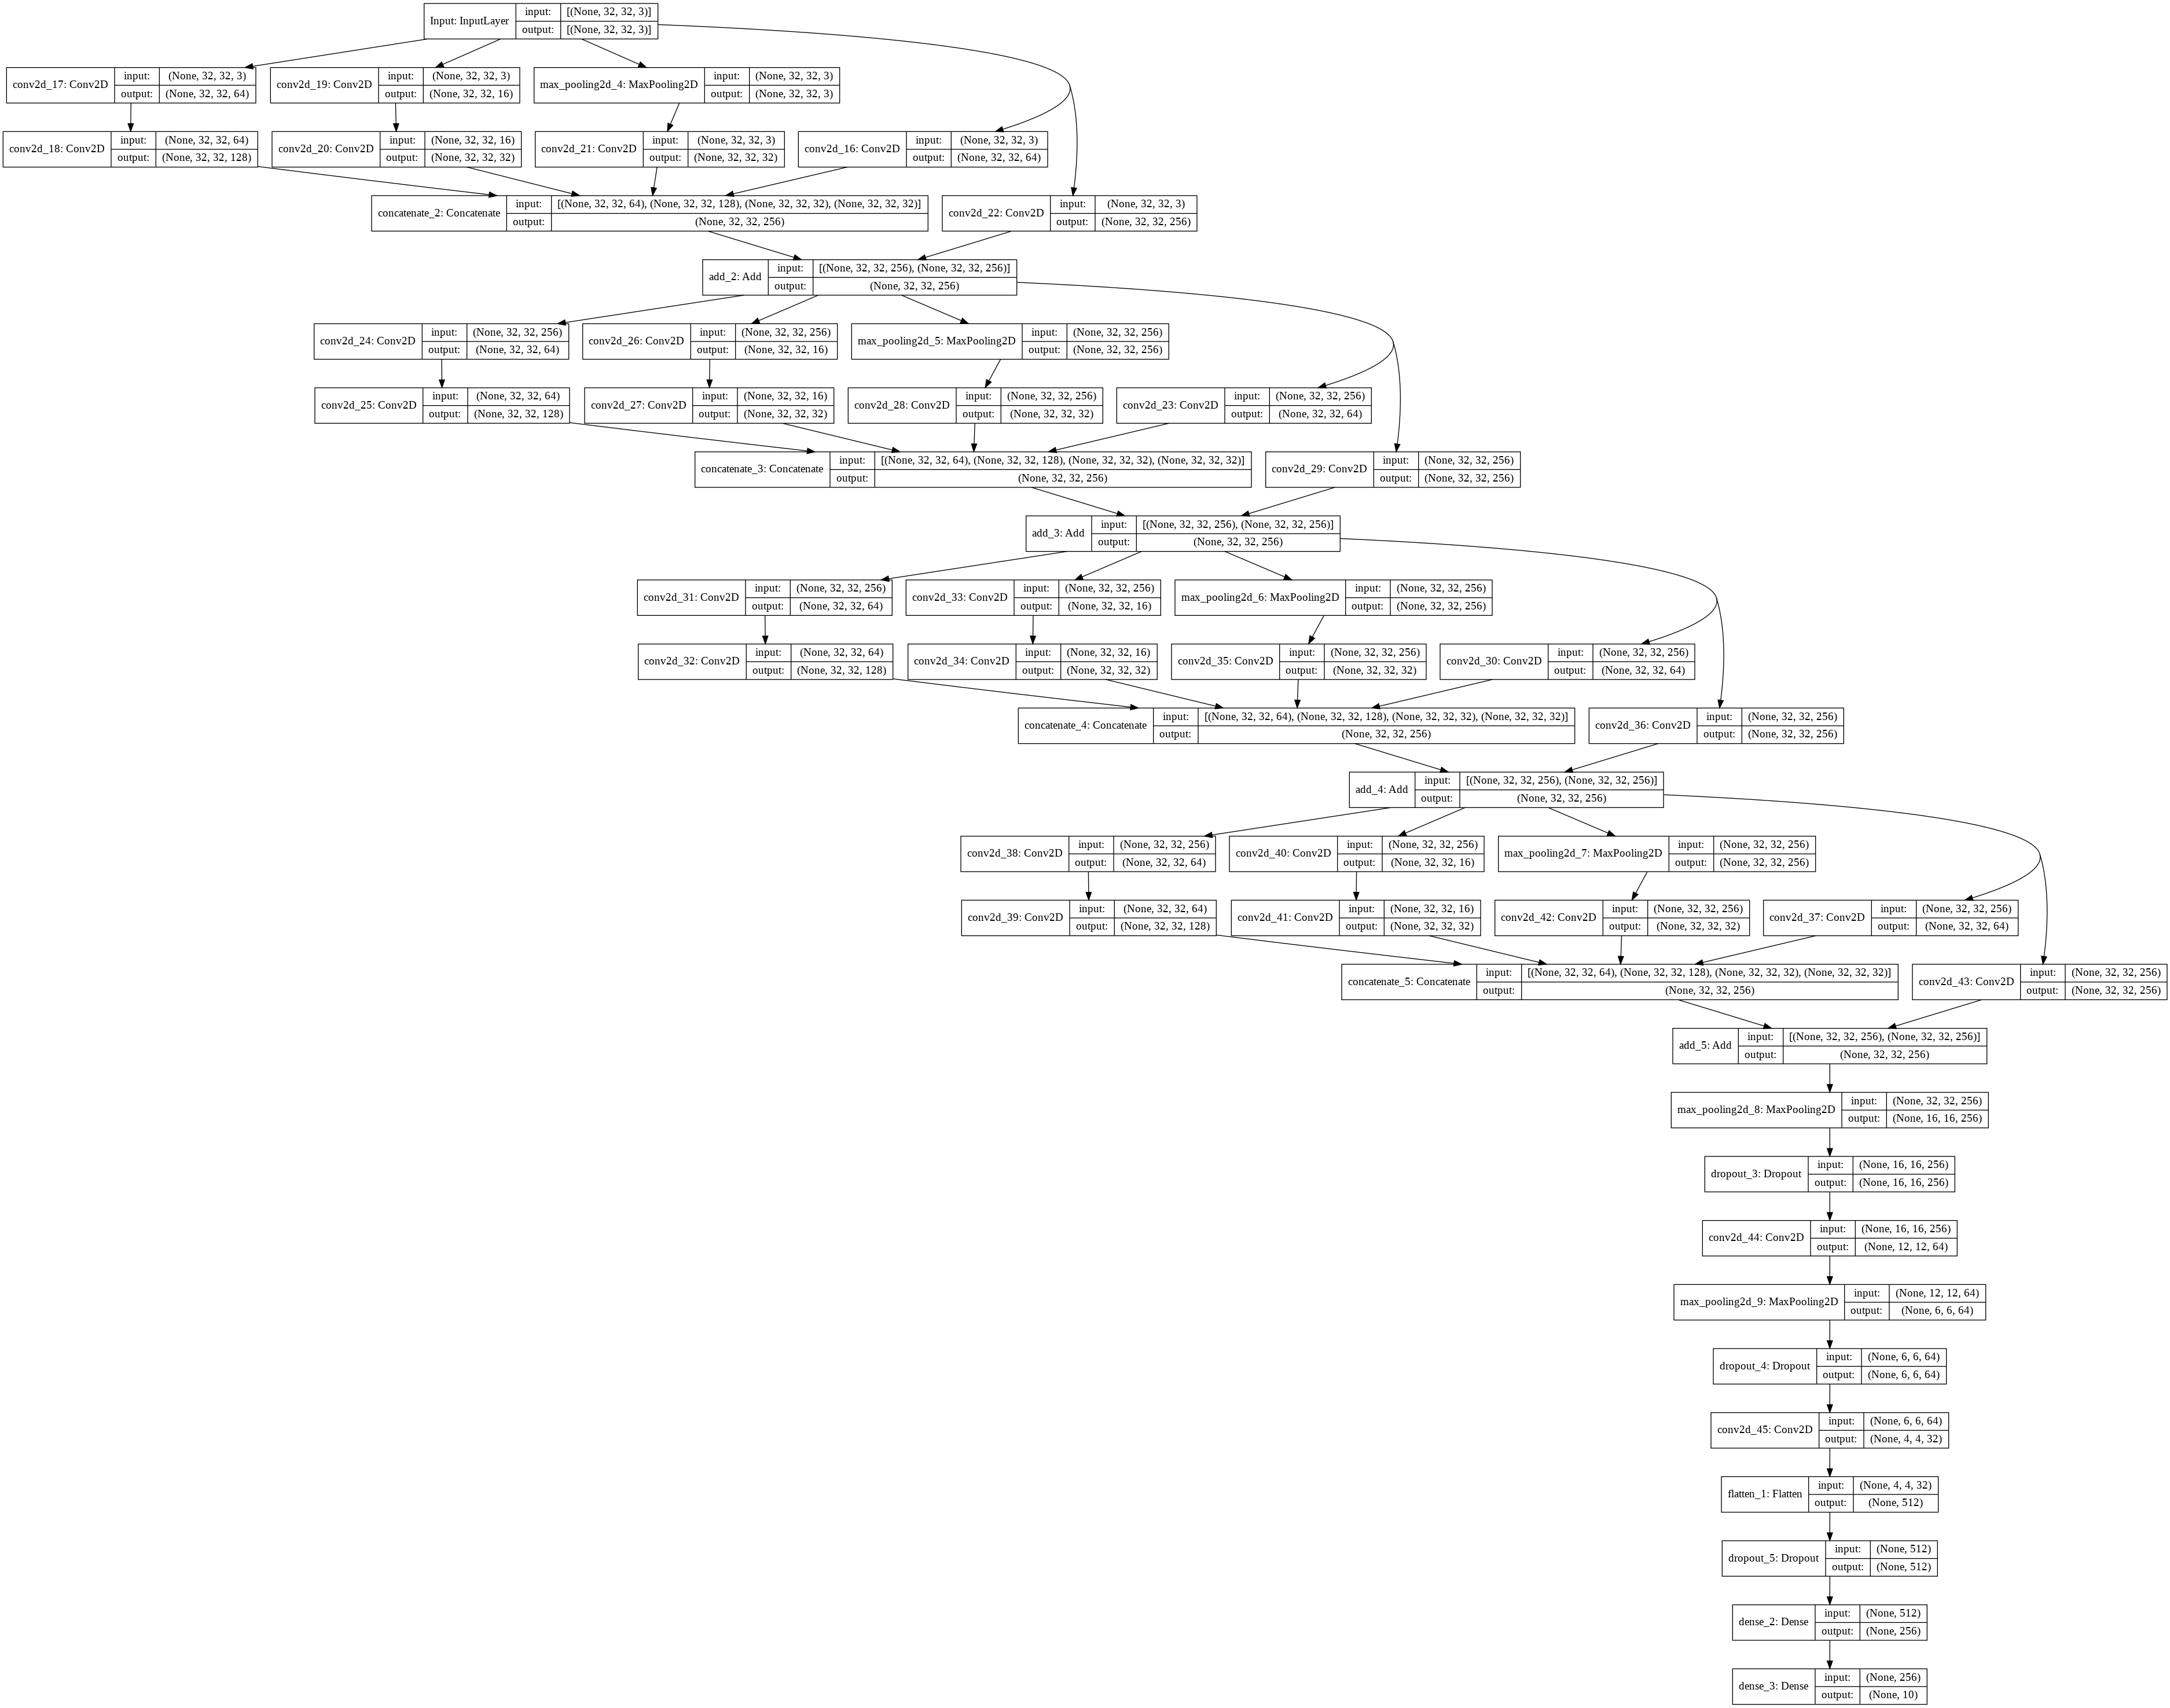

In [12]:
plot_model(model, show_shapes=True)

In [14]:
# Before calling fit, we create the Early Stopping callback. 
# We set it up to stop if improvement in the validation loss 
# does not occur over 10 epochs. When stopping occurs, the 
# weights associated with the best validation loss are restored.
earlyStopping = EarlyStopping(monitor="val_loss", 
                              patience=10,
                              verbose=1,
                              restore_best_weights=True)

# We need to use the one-hot vector version of the labels
# This shouldn't go through all 100 epoches, because of the
# early stopping, but can take some time.
history = model.fit(train_images, 
                    train_labels_array, 
                    epochs=300, 
                    shuffle=True, 
                    callbacks=[earlyStopping],
                    batch_size = 500,
                    validation_split=.2)

Epoch 1/300
80/80 [==============================] - 70s 840ms/step - loss: 2.2948 - accuracy: 0.1056 - val_loss: 2.3026 - val_accuracy: 0.1014
Epoch 2/300
80/80 [==============================] - 67s 834ms/step - loss: 2.2312 - accuracy: 0.1578 - val_loss: 2.1022 - val_accuracy: 0.2366
Epoch 3/300
80/80 [==============================] - 67s 835ms/step - loss: 1.9819 - accuracy: 0.2589 - val_loss: 1.8324 - val_accuracy: 0.3131
Epoch 4/300
80/80 [==============================] - 67s 834ms/step - loss: 1.7767 - accuracy: 0.3277 - val_loss: 1.6629 - val_accuracy: 0.3824
Epoch 5/300
80/80 [==============================] - 67s 835ms/step - loss: 1.6457 - accuracy: 0.3776 - val_loss: 1.5401 - val_accuracy: 0.4268
Epoch 6/300
80/80 [==============================] - 67s 835ms/step - loss: 1.5477 - accuracy: 0.4212 - val_loss: 1.4288 - val_accuracy: 0.4803
Epoch 7/300
80/80 [==============================] - 67s 835ms/step - loss: 1.4509 - accuracy: 0.4644 - val_loss: 1.4242 - val_accuracy:

In [15]:
def plot_training_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model accuracy and loss')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy','Validation Accuracy', 'Loss',
                'Validation Loss'], loc='upper right')
    plt.show()

def test_model(model,x,y):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred,axis=1)
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("Classification report:")
    print(classification_report(y, y_pred))

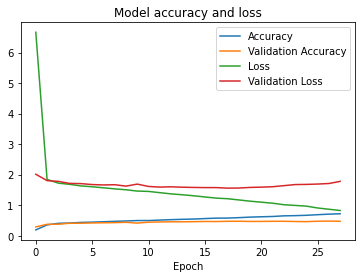

Confusion Matrix:
[[599  33  42  33  37  16  27  17 141  55]
 [ 66 579  29  23  23  22  14  23  69 152]
 [ 99  24 387  71 150  66 119  39  26  19]
 [ 46  25 119 261 104 204 132  38  34  37]
 [ 60   5 142  58 451  60 125  58  29  12]
 [ 28  18 103 202  97 349  95  53  35  20]
 [ 15  17  83  99 129  75 530  19  14  19]
 [ 62  25  82  69 117  81  40 440  24  60]
 [143  57  29  32  37  23   7   5 608  59]
 [ 76 176  17  36  18  27  29  37  86 498]]
Classification report:
              precision    recall  f1-score   support

           0       0.50      0.60      0.55      1000
           1       0.60      0.58      0.59      1000
           2       0.37      0.39      0.38      1000
           3       0.30      0.26      0.28      1000
           4       0.39      0.45      0.42      1000
           5       0.38      0.35      0.36      1000
           6       0.47      0.53      0.50      1000
           7       0.60      0.44      0.51      1000
           8       0.57      0.61      0.

In [ ]:
#baseline model performance
plot_training_history(history)
test_model(model,test_images,test_labels)

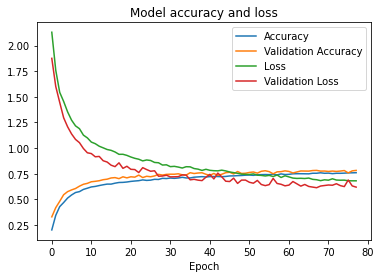

Confusion Matrix:
[[756  13  51  12  20   3  11   8  95  31]
 [  9 858   2   5   2   6  10   4  36  68]
 [ 45   1 685  33  77  57  62  22   8  10]
 [ 16   2  62 570  60 166  77  23  11  13]
 [ 11   1  43  35 790  26  48  37   8   1]
 [  4   1  38 126  38 726  26  29   6   6]
 [  3   3  22  36  23  27 880   3   3   0]
 [ 10   1  31  19  46  62  13 809   5   4]
 [ 23  10  15   9   5   4   2   1 917  14]
 [ 19  46   6   7   2   1   7   4  26 882]]
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1000
           1       0.92      0.86      0.89      1000
           2       0.72      0.69      0.70      1000
           3       0.67      0.57      0.62      1000
           4       0.74      0.79      0.77      1000
           5       0.67      0.73      0.70      1000
           6       0.77      0.88      0.82      1000
           7       0.86      0.81      0.83      1000
           8       0.82      0.92      0.

In [ ]:
# improved baseline model performance
# dropout and additional conv layers to scope down the layers
plot_training_history(history)
test_model(model,test_images,test_labels)

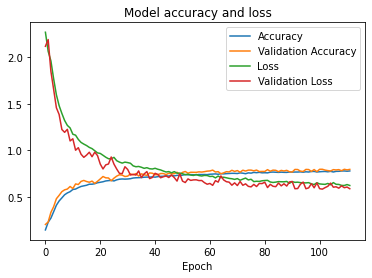

Confusion Matrix:
[[841  12  32   7  10   2   7  10  51  28]
 [  7 892   2   7   2   1   5   1  25  58]
 [ 55   1 719  40  67  46  45  12   8   7]
 [ 21   7  57 659  39 112  64  16  13  12]
 [ 19   1  35  50 791  21  43  31   9   0]
 [ 10   2  52 208  33 645  21  21   4   4]
 [  7   2  31  52  12   8 877   2   6   3]
 [ 14   3  36  39  54  67   7 775   2   3]
 [ 44  20   6  10   2   1   4   1 894  18]
 [ 28  45   3   7   2   3   9   2  28 873]]
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1000
           1       0.91      0.89      0.90      1000
           2       0.74      0.72      0.73      1000
           3       0.61      0.66      0.63      1000
           4       0.78      0.79      0.79      1000
           5       0.71      0.65      0.68      1000
           6       0.81      0.88      0.84      1000
           7       0.89      0.78      0.83      1000
           8       0.86      0.89      0.

In [ ]:
# improved baseline model performance
# more cycle to the conv set layers to increase the layers, totally 19 layers, if counting input
plot_training_history(history)
test_model(model,test_images,test_labels)

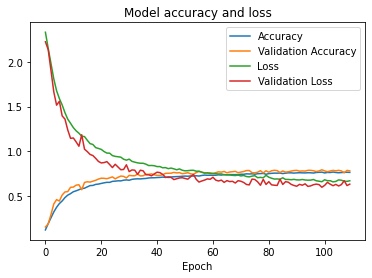

Confusion Matrix:
[[791  29  31  11  10   2  13  14  64  35]
 [  3 902   0   4   2   3   3   5  15  63]
 [ 61   4 665  39  59  59  65  33   6   9]
 [ 13  11  51 539  48 194  71  34  14  25]
 [ 16   4  32  32 772  23  37  74   8   2]
 [  7   4  36 105  29 741  20  53   1   4]
 [  3   5  20  27  22  28 881   5   6   3]
 [ 10   1  21  20  32  48   6 856   1   5]
 [ 40  31   6   9   4   3   2   3 867  35]
 [ 14  60   3   3   1   3   3   3  13 897]]
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1000
           1       0.86      0.90      0.88      1000
           2       0.77      0.67      0.71      1000
           3       0.68      0.54      0.60      1000
           4       0.79      0.77      0.78      1000
           5       0.67      0.74      0.70      1000
           6       0.80      0.88      0.84      1000
           7       0.79      0.86      0.82      1000
           8       0.87      0.87      0.

In [ ]:
# 
# reduced cycle to the conv set layers but with two cov_set, with 3 and 5 strides, totally 21 layers, if counting input
plot_training_history(history)
test_model(model,test_images,test_labels)

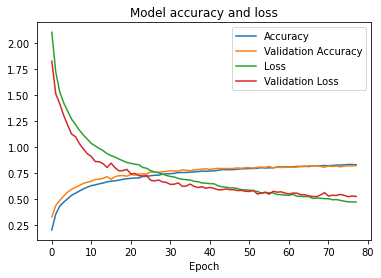

Confusion Matrix:
[[816   9  30  15  23   6  11   7  60  23]
 [ 12 883   2   6   1   5   4   1  19  67]
 [ 51   0 669  44  63  65  71  25   6   6]
 [ 10   0  38 683  43 135  62  10   9  10]
 [  7   0  32  46 789  29  44  46   7   0]
 [  3   0  21 116  33 786  12  25   0   4]
 [  2   1  24  47  13   9 901   1   2   0]
 [ 13   0  24  29  49  61   5 813   1   5]
 [ 35   9   2   9   1   2   4   3 916  19]
 [ 16  31   5   7   1   2   9   1  14 914]]
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1000
           1       0.95      0.88      0.91      1000
           2       0.79      0.67      0.72      1000
           3       0.68      0.68      0.68      1000
           4       0.78      0.79      0.78      1000
           5       0.71      0.79      0.75      1000
           6       0.80      0.90      0.85      1000
           7       0.87      0.81      0.84      1000
           8       0.89      0.92      0.

In [10]:
# combine inception module into residual structure, only one module, 
plot_training_history(history)
test_model(model,test_images,test_labels)

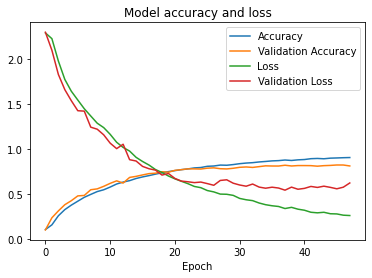

Confusion Matrix:
[[856  12  43   7  13   0   4   9  43  13]
 [ 14 920   2   4   1   1   3   3  16  36]
 [ 58   3 746  35  45  45  36  23   6   3]
 [ 24   9  57 662  46 128  28  31   9   6]
 [ 17   1  50  43 775  13  26  69   5   1]
 [  8   1  39 128  26 743  10  41   1   3]
 [ 11   5  53  64  28   7 826   2   3   1]
 [ 19   1  26  20  31  37   2 860   1   3]
 [ 63  12   8   7   1   1   2   3 888  15]
 [ 29  50   2   6   0   2   4   7  23 877]]
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1000
           1       0.91      0.92      0.91      1000
           2       0.73      0.75      0.74      1000
           3       0.68      0.66      0.67      1000
           4       0.80      0.78      0.79      1000
           5       0.76      0.74      0.75      1000
           6       0.88      0.83      0.85      1000
           7       0.82      0.86      0.84      1000
           8       0.89      0.89      0.

In [16]:
# combine inception module into residual structure, two modules, no repeat, 
plot_training_history(history)
test_model(model,test_images,test_labels)

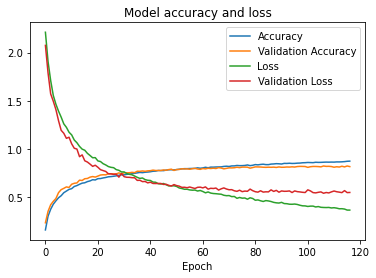

In [ ]:
# combine inception module into residual structure, three modules, repeat 2 twice inside each module, massive training, 
plot_training_history(history)
test_model(model,test_images,test_labels)